In [7]:
import math
import pdb

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data
from torch import nn
import wandb
import networkx as nx

import sys
sys.path.append('../')
import simulation
from modules import AutoEncoderLayers
from utils import set_random_seed_all, print_graph_from_weights, ks_test_screen, compute_p_vals

In [2]:
seed = 0
set_random_seed_all(seed)

n, d = 50, 20
# n, d = 50, 200
n_edges = 5 * d
# n_edges = 10 * d
knockdown_eff = 1.0
B_true = simulation.simulate_dag(d, n_edges, "ER")
X_df, param_dict = simulation.generate_full_interventional_set(
    B_true, n, "mlp", knockdown_eff=1.0
)
X = torch.FloatTensor(X_df.to_numpy()[:, :-1].astype(float))

In [3]:
smask = ks_test_screen(X_df, use_sig=True, sig=0.3, n_parents=None, verbose=True)
pmask = ks_test_screen(X_df, use_sig=False, n_parents=10, verbose=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 226.09it/s]


Fraction edges valid under significance level 0.3: 0.18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 253.75it/s]


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
edges_df = compute_p_vals(X_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 196.88it/s]


(array([38.,  6.,  3.,  0.,  4.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  3.,
         3.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  3.,  1.,  0.,  0.,  0.,
         0.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  2.,  5.,  3.,  2.,  3.,
         3.,  2.,  2.,  4.,  7.,  5.,  3.,  3.,  3.,  2.,  3.,  2.,  3.,
         2.,  2.,  2.,  4.,  3.,  2.,  3.,  3.,  3.,  2.,  3.,  2.,  1.,
         0.,  1.,  4.,  3.,  2.,  3.,  3.,  3.,  2.,  3.,  5.,  6.,  6.,
         5.,  5.,  4.,  3.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,  9.,  9.,
        13., 13., 14., 11., 11.,  9.,  9.,  6.,  4.]),
 array([3.76642815e-27, 1.07947555e-02, 2.15895109e-02, 3.23842664e-02,
        4.31790218e-02, 5.39737773e-02, 6.47685328e-02, 7.55632882e-02,
        8.63580437e-02, 9.71527991e-02, 1.07947555e-01, 1.18742310e-01,
        1.29537066e-01, 1.40331821e-01, 1.51126576e-01, 1.61921332e-01,
        1.72716087e-01, 1.83510843e-01, 1.94305598e-01, 2.05100354e-01,
        2.15895109e-01, 2.26689865e-01, 2.37484620e-01, 2.48279376e-01,
  

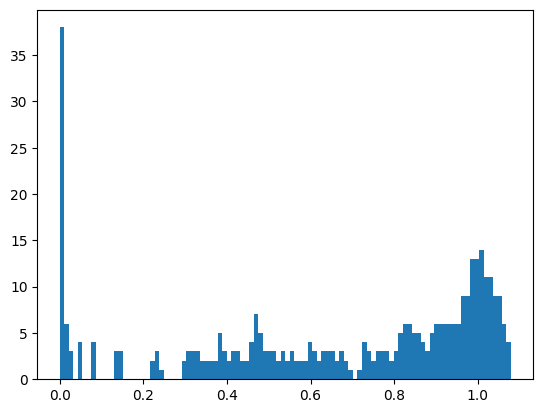

In [13]:
plt.hist(edges_df["pval_adj"].to_numpy().flatten(), bins=100)

(array([51.,  4.,  6.,  6.,  0.,  0., 20.,  0.,  0.,  0.,  0., 26.,  0.,
         0.,  0.,  0.,  0., 35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 25.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        36.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 48.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., 48.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 39.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., 28.,  0.,  0.,  8.]),
 array([1.98233060e-29, 9.97710976e-03, 1.99542195e-02, 2.99313293e-02,
        3.99084391e-02, 4.98855488e-02, 5.98626586e-02, 6.98397684e-02,
        7.98168781e-02, 8.97939879e-02, 9.97710976e-02, 1.09748207e-01,
        1.19725317e-01, 1.29702427e-01, 1.39679537e-01, 1.49656646e-01,
        1.59633756e-01, 1.69610866e-01, 1.79587976e-01, 1.89565086e-01,
        1.99542195e-01, 2.09519305e-01, 2.19496415e-01, 2.29473525e-01,
  

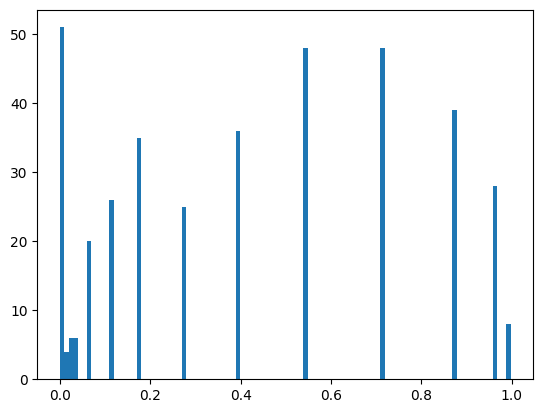

In [14]:
plt.hist(edges_df["pval"].to_numpy().flatten(), bins=100)